In [1]:
from IPython.display import display
import os

# 上傳檔案（會跳出檔案選擇器）
from ipywidgets import FileUpload

upload = FileUpload()
display(upload)

FileUpload(value=(), description='Upload')

In [2]:
import os
from pathlib import Path

# 假設你只上傳了一個檔案
fileinfo = upload.value[0]  # 通常是一個 dict，含 'name' 和 'content'

# 顯示內容結構（除錯用）
print(fileinfo)

# 儲存 kaggle.json
filename = fileinfo['name']
content = fileinfo['content']

kaggle_dir = Path.home() / ".kaggle"
kaggle_dir.mkdir(exist_ok=True)

kaggle_json_path = kaggle_dir / "kaggle.json"
with open(kaggle_json_path, "wb") as f:
    f.write(content)

# 設定權限（Linux/macOS 建議）
os.chmod(kaggle_json_path, 0o600)

print(f"{filename} 已成功儲存至 {kaggle_json_path}")

{'name': 'kaggle.json', 'type': 'application/json', 'size': 64, 'content': <memory at 0x731f52766d00>, 'last_modified': datetime.datetime(2025, 4, 21, 6, 7, 11, 972000, tzinfo=datetime.timezone.utc)}
kaggle.json 已成功儲存至 /home/jovyan/.kaggle/kaggle.json


In [3]:
!kaggle datasets list -s cifar


ref                                                     title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------  ----------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
fedesoriano/cifar100                                    CIFAR-100 Python                                  168517809  2020-12-26 08:37:10.143000          12277        176  1.0              
pankrzysiu/cifar10-python                               CIFAR-10 Python                                   340613496  2018-01-27 13:42:40.967000          14791        252  0.75             
petitbonney/cifar10-image-recognition                   CIFAR-10                                         1007971063  2019-10-01 12:50:23.227000           2870         27  0.8235294        
valentynsichkar/cifar10-preprocessed                   

In [4]:
!pip install -U kaggle
!pip install --upgrade pandas
import os
import zipfile

# 建立 Kaggle 資料夾
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 下載 Dog Breed Identification 資料集
!kaggle competitions download -c dog-breed-identification --force
!unzip -oq dog-breed-identification.zip -d dog-breed-identification


import pandas as pd
import numpy as np

labels = pd.read_csv('dog-breed-identification/labels.csv')


cp: cannot stat 'kaggle.json': No such file or directory
 98%|████████████████████████████████████████ | 675M/691M [00:03<00:00, 186MB/s]
100%|█████████████████████████████████████████| 691M/691M [00:04<00:00, 180MB/s]


/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [5]:
import os
import shutil
import pandas as pd
from PIL import Image
from tqdm import tqdm
# 讀取標籤
labels = pd.read_csv('dog-breed-identification/labels.csv')
# 建立目標輸出資料夾
output_dir = "dog_images"
train_dir = os.path.join(output_dir, "train")
os.makedirs(train_dir, exist_ok=True)

# 根據標籤將圖片存入對應資料夾
def organize_train_images(labels): # Pass labels as an argument
    src_img_dir = "dog-breed-identification/train"
    for idx, row in tqdm(labels.iterrows(), total=len(labels)):
        img_id = row['id']
        breed = row['breed']
        src_path = os.path.join(src_img_dir, img_id + ".jpg")

        # 建立品種對應資料夾
        breed_dir = os.path.join(train_dir, breed)
        os.makedirs(breed_dir, exist_ok=True)

        dst_path = os.path.join(breed_dir, img_id + ".jpg")
        shutil.copyfile(src_path, dst_path)

# Load labels outside the function
labels = pd.read_csv('dog-breed-identification/labels.csv')
organize_train_images(labels) # Call the function with labels argument

100%|██████████| 10222/10222 [00:58<00:00, 174.62it/s]


In [6]:
 #自定義 Dataset 類別
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

from PIL import UnidentifiedImageError
class DogBreedImageFolder(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # 建立類別對應表：品種 → 數值 label
        class_names = sorted(os.listdir(root_dir))
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

        for class_name in class_names:
            class_folder = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_folder):
                continue
            for filename in os.listdir(class_folder):
                if filename.endswith(('.jpg', '.png')):
                    self.image_paths.append(os.path.join(class_folder, filename))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
def collate_fn(batch):
    """
    動態尺寸：因為你的transform固定resize了224x224，
    這裡簡單用 stack，如果你要原始尺寸可改這邊。
    """
    images, labels = zip(*batch)
    images = torch.stack(images, dim=0)
    labels = torch.tensor(labels)
    return images, labels

# ----- MixUp Data Augmentation ----- #

def mixup_data(x, y, alpha=0.4, device='cpu'):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [8]:
# ----- 訓練、驗證函式 ----- #

def train_one_epoch(model, loader, criterion, optimizer, device, alpha=0.4):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        # 使用 MixUp
        inputs, targets_a, targets_b, lam = mixup_data(images, labels, alpha, device)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        # MixUp 的準確率不太準確，可用 targets_a 計算作參考
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(loader)
    val_acc = 100 * correct / total
    return val_loss, val_acc


In [9]:
# ----- EarlyStopping Class ----- #

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [10]:
# 定義 Transform
from torchvision.transforms import RandomResizedCrop, RandomHorizontalFlip, ColorJitter, RandomRotation, ToTensor, Normalize
num_classes = 120
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225)),
])



test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3),
])

In [11]:
# 建立 Dataset 與切分
from torch.utils.data import random_split, DataLoader, WeightedRandomSampler
import collections
from collections import Counter

# 讀取分類後資料
dataset = DogBreedImageFolder("dog_images/train", transform=train_transform)
val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_indices = train_dataset.indices
train_labels = [dataset.labels[i] for i in train_indices]

label_counts = Counter(train_labels)
class_sample_counts = [label_counts[i] for i in range(len(label_counts))]
sample_weights = [1.0 / class_sample_counts[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler,
                          num_workers=2, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,
                        num_workers=2, collate_fn=collate_fn)

# 顯示類別分布（驗證分布仍可看是否合理）
val_labels = [dataset.labels[i] for i in val_dataset.indices]
print("Train label distribution:", Counter(train_labels))
print("Val label distribution:", Counter(val_labels))


Train label distribution: Counter({97: 98, 42: 97, 1: 97, 73: 96, 11: 93, 100: 92, 59: 91, 7: 91, 109: 89, 52: 89, 26: 88, 94: 87, 87: 87, 3: 86, 69: 84, 17: 84, 93: 84, 75: 82, 9: 82, 80: 81, 6: 81, 61: 81, 13: 80, 86: 79, 84: 79, 68: 78, 88: 78, 102: 77, 35: 76, 70: 74, 117: 73, 39: 73, 30: 72, 0: 72, 82: 72, 28: 72, 101: 72, 64: 71, 33: 71, 56: 70, 37: 70, 78: 70, 53: 70, 57: 70, 67: 70, 20: 70, 15: 69, 60: 69, 19: 69, 63: 69, 14: 69, 105: 69, 90: 69, 62: 68, 116: 68, 79: 68, 2: 68, 110: 68, 95: 67, 98: 67, 114: 66, 40: 66, 71: 66, 36: 66, 104: 65, 118: 65, 8: 65, 25: 64, 77: 64, 54: 64, 10: 63, 96: 63, 91: 63, 74: 63, 55: 62, 111: 62, 92: 62, 50: 61, 89: 61, 5: 61, 18: 61, 27: 61, 115: 61, 66: 60, 4: 60, 47: 60, 119: 60, 72: 60, 76: 59, 108: 59, 41: 59, 24: 59, 99: 58, 81: 58, 106: 58, 38: 58, 34: 58, 103: 57, 58: 57, 31: 57, 29: 56, 51: 56, 85: 56, 16: 56, 44: 56, 107: 56, 46: 55, 22: 54, 21: 54, 32: 54, 49: 54, 43: 53, 113: 52, 65: 52, 48: 52, 12: 52, 45: 52, 83: 51, 112: 51, 23:

In [12]:
#驗證資料載入
# 驗證一個 batch
for images, labels in train_loader:
    print("Images shape:", images.shape)  # [B, 3, 224, 224]
    print("Labels shape:", labels.shape)  # [B]
    break

Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


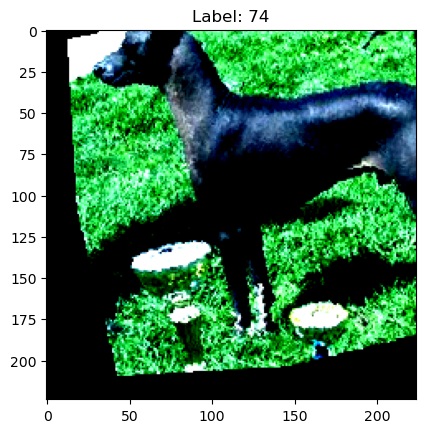

In [13]:
# 如果需要視覺化一個 batch
import matplotlib.pyplot as plt
def show_batch(loader):
    images, labels = next(iter(loader))
    img = images[0].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(f"Label: {labels[0]}")
    plt.show()

show_batch(train_loader)

In [14]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()


In [15]:
!pip install timm


In [16]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import timm

# timm 中的 xception 模型，使用預訓練權重
model = timm.create_model('xception', pretrained=True, num_classes=num_classes)


# 搬移到裝置（GPU 或 CPU）
model = model.to(device)

/opt/conda/lib/python3.9/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [17]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR
num_epochs = 30
# 1. 計算 class weights（根據整體 dataset 分布）
from collections import Counter

label_counts = Counter(dataset.labels)
class_counts = [label_counts[i] for i in range(num_classes)]

# 權重：類別樣本越少，損失權重越高
weights = [1.0 / c for c in class_counts]
weights = torch.tensor(weights, dtype=torch.float).to(device)
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
# 定義損失函數與優化器
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Scheduler: Warmup + CosineAnnealingLR
from torch.optim.lr_scheduler import CosineAnnealingLR

class GradualWarmupScheduler(optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        self.multiplier = multiplier
        self.total_epoch = total_epoch
        self.after_scheduler = after_scheduler
        self.finished = False
        super(GradualWarmupScheduler, self).__init__(optimizer)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]

        return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if self.finished and self.after_scheduler:
            if epoch is None:
                self.after_scheduler.step(None)
            else:
                self.after_scheduler.step(epoch - self.total_epoch)
        else:
            return super(GradualWarmupScheduler, self).step(epoch)

cosine_scheduler = CosineAnnealingLR(optimizer, T_max=30 - 5)  # 30 epochs, 5 warmup
scheduler = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=5, after_scheduler=cosine_scheduler)


In [22]:
epochs = 30
early_stopping = EarlyStopping(patience=7, verbose=True, path='best_model.pth')

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    print(f"Epoch [{epoch + 1}/{epochs}]")

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.2f}%")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

    scheduler.step()

print("Training complete.")

Epoch [1/30]
Train Loss: 1.4509, Train Acc: 45.90%
Val   Loss: 0.8670, Val   Acc: 78.57%
Validation loss decreased (inf --> 0.866958).  Saving model ...
Epoch [2/30]
Train Loss: 1.4272, Train Acc: 49.41%
Val   Loss: 0.8352, Val   Acc: 79.06%
Validation loss decreased (0.866958 --> 0.835198).  Saving model ...
Epoch [3/30]
Train Loss: 1.4437, Train Acc: 49.94%
Val   Loss: 0.8718, Val   Acc: 77.25%
EarlyStopping counter: 1 out of 7
Epoch [4/30]
Train Loss: 1.4067, Train Acc: 47.31%
Val   Loss: 0.9279, Val   Acc: 78.08%
EarlyStopping counter: 2 out of 7
Epoch [5/30]
Train Loss: 1.3063, Train Acc: 48.06%
Val   Loss: 0.8538, Val   Acc: 78.03%
EarlyStopping counter: 3 out of 7
Epoch [6/30]
Train Loss: 1.3072, Train Acc: 48.14%
Val   Loss: 0.8165, Val   Acc: 78.47%
Validation loss decreased (0.835198 --> 0.816479).  Saving model ...
Epoch [7/30]
Train Loss: 1.4547, Train Acc: 47.82%
Val   Loss: 0.8326, Val   Acc: 79.01%
EarlyStopping counter: 1 out of 7
Epoch [8/30]
Train Loss: 1.4198, Train 

In [23]:
# ----- 載入最佳模型 ----- #
model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [31]:
# --- 測試 Dataset 類別定義 ---
class TestImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_filenames = sorted(os.listdir(image_folder))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_name.split('.')[0]  # 傳回 image tensor 和 id（不含 .jpg）

# --- 修正 test transform（與訓練一致）---
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 根據你訓練用的 input size 調整
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),  # ImageNet mean
                         (0.229, 0.224, 0.225))  # ImageNet std
])

# --- 測試集路徑 ---
test_folder = 'dog-breed-identification/test'

# --- 建立 Test Dataset 與 DataLoader ---
test_dataset = TestImageDataset(test_folder, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# --- 類別名稱與映射 (從訓練 dataset 取得 class_to_idx) ---
all_breeds = sorted(dataset.class_to_idx.keys())  # dataset 為你訓練時的 train_dataset
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}


In [33]:
# --- 模型推論 ---
model.eval()
submission = []

with torch.no_grad():
    for inputs, image_ids in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()

        for img_id, prob_vector in zip(image_ids, probs):
            row = {"id": img_id}
            for breed, prob in zip(all_breeds, prob_vector):
                row[breed] = prob
            submission.append(row)

# --- 儲存 submission.csv ---
submission_df = pd.DataFrame(submission)
submission_df = submission_df[["id"] + all_breeds]  # 確保順序正確
submission_df.to_csv("submission00.csv", index=False)
print("✅ submission.csv 已成功輸出，格式符合 Kaggle 要求！")

✅ submission.csv 已成功輸出，格式符合 Kaggle 要求！


In [47]:
# ----- 測試資料推論 ----- #

# 測試資料路徑與轉換
test_dir = 'dog-breed-identification/test'
test_df = pd.read_csv('dog-breed-identification/sample_submission.csv', dtype={'id': str})
test_image_ids = test_df['id'].tolist()

all_breeds = list(test_df.columns[1:])  # 取得所有 breed


class TestDataset(Dataset):
    def __init__(self, image_dir, image_ids, transform=None):
        self.image_dir = image_dir
        self.image_ids = image_ids
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        path = os.path.join(self.image_dir, str(image_id) + ".jpg")

        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, image_id


test_dataset = TestDataset(test_dir, test_image_ids, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

model.eval()
submission = []

with torch.no_grad():
    for inputs, image_ids in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()

        for img_id, prob_vector in zip(image_ids, probs):
            row = {"id": img_id}
            for i, breed in enumerate(all_breeds):
                row[breed] = prob_vector[i]
            submission.append(row)

submission_df = pd.DataFrame(submission)
submission_df.to_csv("submission000.csv", index=False)
print("submission.csv 已產生完成。") 

submission.csv 已產生完成。
